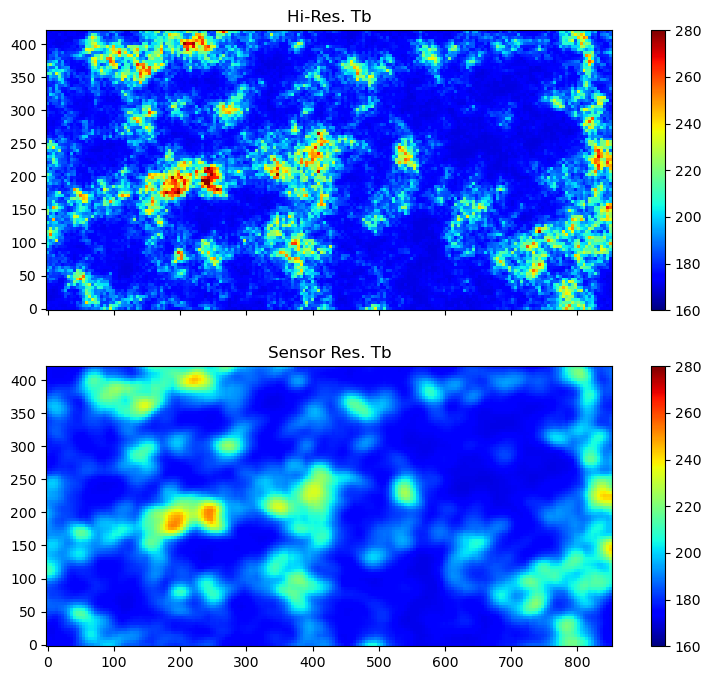

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from gstools import SRF

with open('fit_model.pkl','rb') as f:
    fit_model=pickle.load(f)["fit_model"]

seed_value=19770938
attKuCoeff=(1.08783315, -3.61981317)
from scipy.signal import convolve2d 

gainField=np.zeros((7,5))
for i in range(7):
    for j in range(5):
        gainField[i,j]=np.exp(-4*np.log(2)*(((i-3)*4.5)**2/32**2+((j-2)*4.5)**2/19**2))

gainField=gainField/gainField.sum()
def simTb(seed_value,attKuCoeff):
    srf = SRF(fit_model, seed=seed_value)
    x_s, y_s = range(2*98),range(2*49)
    new_logR = srf((x_s, y_s), mesh_type='structured')
    genRainField=np.exp(new_logR-1.25)*6.5
    attKu=np.exp(attKuCoeff[0]*np.log(genRainField)+attKuCoeff[1])*9
    tb=282-np.exp((attKu-20.043)/(-4.247))
    tb2dConv=convolve2d(tb, gainField, mode='valid')
    return tb2dConv,tb,genRainField

tb2dConv_2,tb_2,genRainField_2=simTb(seed_value,attKuCoeff)

plt.figure(figsize=(10,8))
ax1=plt.subplot(212)
c1=ax1.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb2dConv_2.T,cmap='jet',vmin=160,vmax=280)
ax1.set_aspect('equal')
plt.title('Sensor Res. Tb')
plt.colorbar(c1)
ax2=plt.subplot(211)
c2=ax2.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb_2[3:-3,2:-2].T,cmap='jet',vmin=160,vmax=280)
plt.title('Hi-Res. Tb')
ax2.set_aspect('equal')
ax2.set_xticklabels([])
plt.colorbar(c2)
plt.savefig('Tb.png',dpi=300,bbox_inches='tight')



In [140]:
from uNet2 import unet_model

uNetDeconv2=unet_model(n_filters=32)
uNetDeconv2.compile(optimizer='adam', loss='mse')

In [75]:
print(tb2dConv_2.mean(),tb2dConv_2.std())
tbm=188
tbs=14
def create_dataset(attKuCoeff):
    Xs, ys = [], []
    for i in range(50):
        #print(i,len(Xs))
        seed_value=np.random.randint(0,100000000)
        tb2dConv_2,tb_2,genRainField_2=simTb(seed_value,attKuCoeff)
        for irepeat in range(30):
            isamp=np.random.randint(3+32,190-3-32)
            jsamp=np.random.randint(2+32,94-2-32)
            X1=(tb2dConv_2[isamp-32:isamp+32,jsamp-32:jsamp+32]-tbm)/1.5/tbs
            y1=(tb_2[isamp-32+3:isamp+32+3,jsamp-32+3:jsamp+32+3]-tbm)/1.5/tbs
            Xs.append(X1[:,:,np.newaxis])
            ys.append(y1[:,:,np.newaxis])
    return np.array(Xs),np.array(ys)

187.91693879922258 14.138255659984846


In [76]:
X_train,y_train=create_dataset(attKuCoeff)
X_test,y_test=create_dataset(attKuCoeff)
print(X_train.shape,y_train.shape)

(1500, 64, 64, 1) (1500, 64, 64, 1)


In [92]:
#uNetDeconv.summary()
hist=uNetDeconv2.fit(X_train, y_train, epochs=20, batch_size=32,validation_data=(X_test, y_test),verbose=1)


Epoch 1/20
47/47 [==============================] - 12s 220ms/step - loss: 0.2268 - val_loss: 0.1526
Epoch 2/20
47/47 [==============================] - 10s 210ms/step - loss: 0.1539 - val_loss: 0.1311
Epoch 3/20
47/47 [==============================] - 10s 212ms/step - loss: 0.1367 - val_loss: 0.1176
Epoch 4/20
47/47 [==============================] - 10s 209ms/step - loss: 0.1224 - val_loss: 0.1082
Epoch 5/20
47/47 [==============================] - 10s 211ms/step - loss: 0.1127 - val_loss: 0.1000
Epoch 6/20
47/47 [==============================] - 10s 209ms/step - loss: 0.1056 - val_loss: 0.0947
Epoch 7/20
47/47 [==============================] - 10s 212ms/step - loss: 0.1002 - val_loss: 0.0908
Epoch 8/20
47/47 [==============================] - 10s 208ms/step - loss: 0.0962 - val_loss: 0.0878
Epoch 9/20
47/47 [==============================] - 10s 209ms/step - loss: 0.0928 - val_loss: 0.0850
Epoch 10/20
47/47 [==============================] - 10s 209ms/step - loss: 0.0899 - val_lo

In [139]:
#save model
uNetDeconv2.save('uNetDeconv_32chan.h5')

In [95]:
hist=uNetDeconv.fit(X_train, y_train, epochs=10, batch_size=32,validation_data=(X_test, y_test),verbose=1)
y_pred=uNetDeconv.predict(X_test)
np.corrcoef(X_test.flatten(),y_test.flatten())
np.corrcoef(y_test.flatten(),y_pred.flatten())


Epoch 1/10
47/47 [==============================] - 10s 223ms/step - loss: 0.0726 - val_loss: 0.0683
Epoch 2/10
47/47 [==============================] - 10s 223ms/step - loss: 0.0718 - val_loss: 0.0677
Epoch 3/10
47/47 [==============================] - 10s 224ms/step - loss: 0.0709 - val_loss: 0.0670
Epoch 4/10
47/47 [==============================] - 10s 215ms/step - loss: 0.0698 - val_loss: 0.0663
Epoch 5/10
47/47 [==============================] - 10s 223ms/step - loss: 0.0690 - val_loss: 0.0658
Epoch 6/10
47/47 [==============================] - 10s 224ms/step - loss: 0.0684 - val_loss: 0.0661
Epoch 7/10
47/47 [==============================] - 10s 221ms/step - loss: 0.0676 - val_loss: 0.0646
Epoch 8/10
47/47 [==============================] - 10s 219ms/step - loss: 0.0667 - val_loss: 0.0642
Epoch 9/10
47/47 [==============================] - 10s 219ms/step - loss: 0.0660 - val_loss: 0.0638
Epoch 10/10
47/47 [==============================] - 3s 54ms/step


array([[1.        , 0.95604598],
       [0.95604598, 1.        ]])

0.1444789626252282 0.2343495614596305


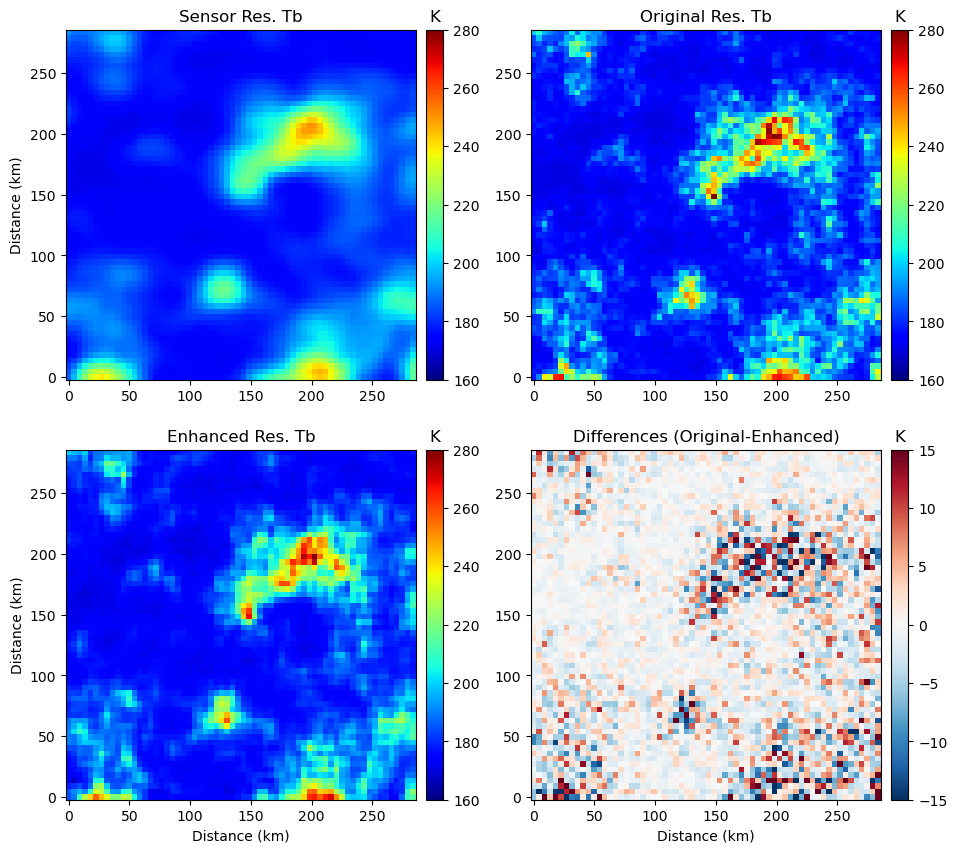

In [138]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(11,10))
x=np.arange(64)*4.5
y=np.arange(64)*4.5
ax1=plt.subplot(221)
c1=plt.pcolormesh(x,y,(1.5*tbs*X_test[0,:,:,0]+tbm).T,cmap='jet',vmin=160,vmax=280)
plt.ylabel('Distance (km)')
plt.title('Sensor Res. Tb')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cb1=plt.colorbar(c1,cax=cax1)
plt.title('K')
ax1.set_aspect('equal')
ax2=plt.subplot(222)
c2=plt.pcolormesh(x,y,(1.5*tbs*y_test[0,:,:,0]+tbm).T,cmap='jet',vmin=160,vmax=280)
plt.title('Original Res. Tb')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.1)
ax2.set_aspect('equal')
cb2=plt.colorbar(c2,cax=cax2)
plt.title('K')

ax3=plt.subplot(223)
c3=plt.pcolormesh(x,y,(1.5*tbs*y_pred[0,:,:,0]+tbm).T,cmap='jet',vmin=160,vmax=280)
ax3.set_aspect('equal')
divider = make_axes_locatable(ax3)
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.title('Enhanced Res. Tb')
cax3 = divider.append_axes("right", size="5%", pad=0.1)
plt.title('K')
cb3=plt.colorbar(c3,cax=cax3)
ax4=plt.subplot(224)


plt.pcolormesh(x,y,1.5*tbs*(y_test[0,:,:,0]-y_pred[0,:,:,0]).T,cmap='RdBu_r',vmin=-15,vmax=15)
plt.title('Differences (Original-Enhanced)')
ax4.set_xlabel('Distance (km)')
divider = make_axes_locatable(ax4)
cax4 = divider.append_axes("right", size="5%", pad=0.1)
ax4.set_aspect('equal')
plt.colorbar(cax=cax4)
plt.title('K')
print(np.abs(y_test[0,:,:,0]-y_pred[0,:,:,0]).mean(),np.abs(y_test[0,:,:,0]-X_test[0,:,:,0]).mean())
plt.savefig('DeConvolution_10GHz.png',dpi=300,bbox_inches='tight')

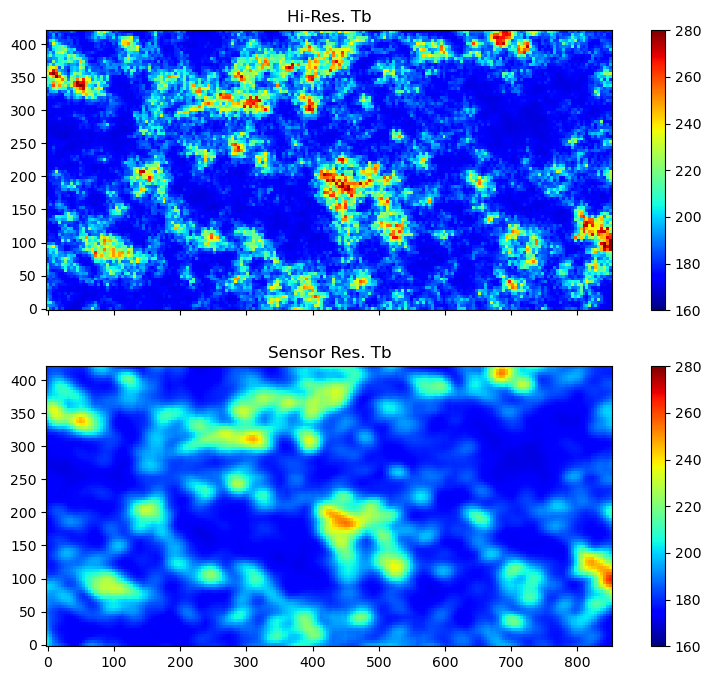

In [36]:
seed_value=19780938
attKuCoeff=(1.08783315, -3.61981317)
from scipy.signal import convolve2d 

gainField=np.zeros((7,5))
for i in range(7):
    for j in range(5):
        gainField[i,j]=np.exp(-4*np.log(2)*(((i-3)*4.5)**2/32**2+((j-2)*4.5)**2/19**2))

gainField=gainField/gainField.sum()
def simTb(seed_value,attKuCoeff):
    srf = SRF(fit_model, seed=seed_value)
    x_s, y_s = range(2*98),range(2*49)
    new_logR = srf((x_s, y_s), mesh_type='structured')
    genRainField=np.exp(new_logR-1.25)*6.5
    attKu=np.exp(attKuCoeff[0]*np.log(genRainField)+attKuCoeff[1])*9
    tb=282-np.exp((attKu-20.043)/(-4.247))
    tb2dConv=convolve2d(tb, gainField, mode='valid')
    return tb2dConv,tb,genRainField

tb2dConv_2,tb_2,genRainField_2=simTb(seed_value,attKuCoeff)

plt.figure(figsize=(10,8))
ax1=plt.subplot(212)
c1=ax1.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb2dConv_2.T,cmap='jet',vmin=160,vmax=280)
ax1.set_aspect('equal')
plt.title('Sensor Res. Tb')
plt.colorbar(c1)
ax2=plt.subplot(211)
c2=ax2.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb_2[3:-3,2:-2].T,cmap='jet',vmin=160,vmax=280)
plt.title('Hi-Res. Tb')
ax2.set_aspect('equal')
ax2.set_xticklabels([])
plt.colorbar(c2)
plt.savefig('Tb.png',dpi=300,bbox_inches='tight')

(190, 94)
(190, 94)
(196, 98)
[[1.         0.87403569]
 [0.87403569 1.        ]]


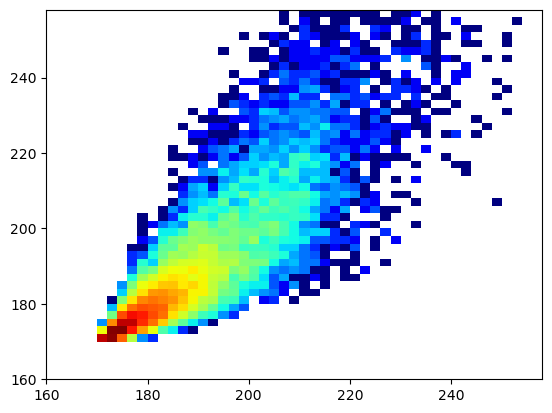

In [35]:
from skimage import color, data, restoration
import matplotlib.colors
tb_deconv=tb2dConv_2.copy()
print(tb_deconv.shape)
print(tb2dConv_2.shape)
print(convolve2d(tb_deconv, gainField, mode='full').shape)
print(np.corrcoef(tb2dConv_2.flatten(),tb_2[3:-3,2:-2].flatten()))
hist=plt.hist2d(tb2dConv_2.flatten(),tb_2[3:-3,2:-2].flatten(),bins=160+np.arange(50)*2,cmap='jet',norm=matplotlib.colors.LogNorm())
#for i in range(5):
#    tb_deconv=tb_deconv+(tb2dConv_2-convolve2d(tb_deconv, gainField, mode='full')[3:-3,2:-2])

#plt.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb_deconv[:,:].T,cmap='jet',vmin=160,vmax=280)
